# 📝 Exercise M4.02

In the previous notebook, we showed that we can add new features based on the
original feature `x` to make the model more expressive, for instance `x ** 2` or
`x ** 3`. In that case we only used a single feature in `data`.

The aim of this notebook is to train a linear regression algorithm on a
dataset with more than a single feature. In such a "multi-dimensional" feature
space we can derive new features of the form `x1 * x2`, `x2 * x3`, etc.
Products of features are usually called "non-linear" or "multiplicative"
interactions between features.

Feature engineering can be an important step of a model pipeline as long as
the new features are expected to be predictive. For instance, think of a
classification model to decide if a patient has risk of developing a heart
disease. This would depend on the patient's Body Mass Index which is defined
as `weight / height ** 2`.

We load the dataset penguins dataset. We first use a set of 3 numerical
features to predict the target, i.e. the body mass of the penguin.

<div class="admonition note alert alert-info">
<p class="first admonition-title" style="font-weight: bold;">Note</p>
<p class="last">If you want a deeper overview regarding this dataset, you can refer to the
Appendix - Datasets description section at the end of this MOOC.</p>
</div>

In [1]:
import pandas as pd

penguins = pd.read_csv("../datasets/penguins.csv")

columns = ["Flipper Length (mm)", "Culmen Length (mm)", "Culmen Depth (mm)"]
target_name = "Body Mass (g)"

# Remove lines with missing values for the columns of interest
penguins_non_missing = penguins[columns + [target_name]].dropna()

data = penguins_non_missing[columns]
target = penguins_non_missing[target_name]
data.head()

,Flipper Length (mm),Culmen Length (mm),Culmen Depth (mm)
0,181.0,39.1,18.7
1,186.0,39.5,17.4
2,195.0,40.3,18.0
4,193.0,36.7,19.3
5,190.0,39.3,20.6


Now it is your turn to train a linear regression model on this dataset. First,
create a linear regression model.

In [3]:
# Write your code here.
from sklearn.linear_model import LinearRegression

model = LinearRegression()


Execute a cross-validation with 10 folds and use the mean absolute error (MAE)
as metric.

In [4]:
# Write your code here.
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_absolute_error 

cv_results = cross_validate(
    model,
    data,
    target,
    cv=10,
    scoring='neg_mean_absolute_error'
)



Compute the mean and std of the MAE in grams (g). Remember you have to revert
the sign introduced when metrics start with `neg_`, such as in
`"neg_mean_absolute_error"`.

In [5]:
# Write your code here.
cv_results = pd.DataFrame(cv_results)
cv_results['test_score'] = -cv_results['test_score']
print(
    f"Mean error: {cv_results['test_score'].mean()}\n"
    f"Std = {cv_results['test_score'].std()}"
)

Mean error: 337.07133738443895
Std = 89.45915839307133


Now create a pipeline using `make_pipeline` consisting of a
`PolynomialFeatures` and a linear regression. Set `degree=2` and
`interaction_only=True` to the feature engineering step. Remember not to
include a "bias" feature (that is a constant-valued feature) to avoid
introducing a redundancy with the intercept of the subsequent linear
regression model.

You may want to use the `.set_output(transform="pandas")` method of the
pipeline to answer the next question.

In [25]:
# Write your code here.
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

model = make_pipeline(
    PolynomialFeatures(
        degree=2, 
        interaction_only=True, 
        include_bias=False
    ).set_output(transform='pandas'),
    LinearRegression()
)


Transform the first 5 rows of the dataset and look at the column names. How
many features are generated at the output of the `PolynomialFeatures` step in
the previous pipeline?

In [27]:
# Write your code here.
tmp = model['polynomialfeatures'].fit_transform(data.head(5))
print(f"Number of features generated at the PolynomialFeatures step: {tmp.shape[1]-data.shape[1]}")
tmp.head(5)

Number of features generated at the PolynomialFeatures step: 3


,Flipper Length (mm),Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm) Culmen Length (mm),Flipper Length (mm) Culmen Depth (mm),Culmen Length (mm) Culmen Depth (mm)
0,181.0,39.1,18.7,7077.1,3384.7,731.17
1,186.0,39.5,17.4,7347.0,3236.4,687.30
2,195.0,40.3,18.0,7858.5,3510.0,725.40
4,193.0,36.7,19.3,7083.1,3724.9,708.31
5,190.0,39.3,20.6,7467.0,3914.0,809.58


Check that the values for the new interaction features are correct for a few
of them.

In [24]:
# Write your code here.
test = tmp['Flipper Length (mm)']*tmp['Culmen Length (mm)'] - tmp['Flipper Length (mm) Culmen Length (mm)']
print((test==0).all())

test = tmp['Flipper Length (mm)']*tmp['Culmen Depth (mm)'] - tmp['Flipper Length (mm) Culmen Depth (mm)']
print((test==0).all())

test = tmp['Culmen Length (mm)']*tmp['Culmen Depth (mm)'] - tmp['Culmen Length (mm) Culmen Depth (mm)']
print((test==0).all())


True
True
True


Use the same cross-validation strategy as done previously to estimate the mean
and std of the MAE in grams (g) for such a pipeline. Compare with the results
without feature engineering.

In [29]:
# Write your code here.

cv_results = cross_validate(
    model, 
    data,
    target,
    cv=10,
    scoring='neg_mean_absolute_error'
)
cv_results = pd.DataFrame(cv_results)
cv_results['test_score'] = -cv_results['test_score']
print(
    f"Mean error: {cv_results['test_score'].mean()}\n"
    f"Std = {cv_results['test_score'].std()}"
)

Mean error: 301.789552284324
Std = 46.73847205967983



Now let's try to build an alternative pipeline with an adjustable number of
intermediate features while keeping a similar predictive power. To do so, try
using the `Nystroem` transformer instead of `PolynomialFeatures`. Set the
kernel parameter to `"poly"` and `degree` to 2. Adjust the number of
components to be as small as possible while keeping a good cross-validation
performance.

Hint: Use a `ValidationCurveDisplay` with `param_range = np.array([5, 10, 50,
100])` to find the optimal `n_components`.

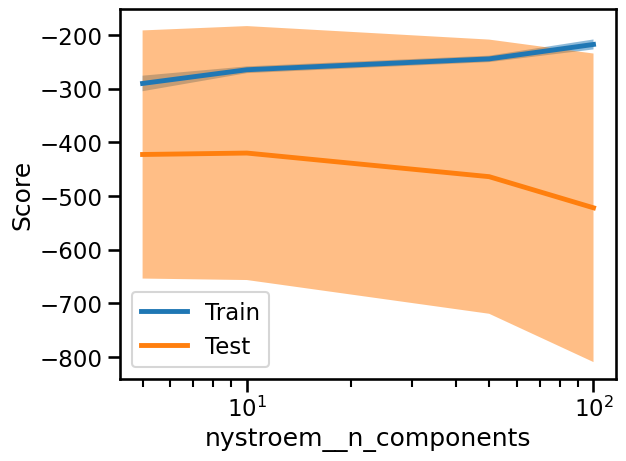

In [38]:
# Write your code here.
import numpy as np
from sklearn.kernel_approximation import Nystroem
from sklearn.model_selection import ValidationCurveDisplay, validation_curve




nystroem_regression = make_pipeline(
    Nystroem(kernel="poly", degree=2, random_state=0),
    LinearRegression(),
)
nystroem_regression

param_name='nystroem__n_components'
param_range = np.array([5, 10, 50, 100])
train_scores, test_scores = validation_curve(
    nystroem_regression, data, target, param_name=param_name, param_range=param_range,
    scoring='neg_mean_absolute_error'
)
display = ValidationCurveDisplay(
    param_name=param_name, param_range=param_range,
    train_scores=train_scores, test_scores=test_scores, score_name="Score"
)
display.plot()

How do the mean and std of the MAE for the Nystroem pipeline with optimal
`n_components` compare to the other previous models?

In [37]:
# Write your code here.
nystroem_regression = make_pipeline(
    Nystroem(kernel="poly", degree=2, n_components=10, random_state=0),
    LinearRegression(),
)


cv_results = cross_validate(
    nystroem_regression, 
    data,
    target,
    cv=10,
    scoring='neg_mean_absolute_error'
)
cv_results = pd.DataFrame(cv_results)
cv_results['test_score'] = -cv_results['test_score']
print(
    f"Mean error: {cv_results['test_score'].mean()}\n"
    f"Std = {cv_results['test_score'].std()}"
)

Mean error: 299.0870846025061
Std = 47.30154272350819
